<a href="https://colab.research.google.com/github/KaifAhmad1/Audio-Emotion-Analysis/blob/main/Audio_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Audio Data Preprocessing and Audio Sentiment and Emotion Analysis:

**Installing Necessary Dependencies:**

In [24]:
!pip install -qU \
     librosa \
     plotly

In [25]:
import os
import numpy as np
import pandas as pd
import librosa
import plotly.graph_objects as go
import plotly.io as pio
from skimage.io import imread

In [26]:
# Set seed for reproducibility
seed = 12
np.random.seed(seed)

In [27]:
trainset_data = '/content/drive/MyDrive/audio-sentiment-data/TEST'
testset_data = '/content/drive/MyDrive/audio-sentiment-data/TRAIN'
file_path = '/content/drive/MyDrive/audio-sentiment-data/speech-emotion-data.csv'
speech_data = pd.read_csv(file_path)

In [28]:
trainset_data

'/content/drive/MyDrive/audio-sentiment-data/TEST'

In [29]:
testset_data

'/content/drive/MyDrive/audio-sentiment-data/TRAIN'

**Data Exploration:**

In [30]:
print(speech_data)

    Filename     Class
0    346.wav  Negative
1    163.wav   Neutral
2    288.wav  Negative
3    279.wav  Negative
4    244.wav  Negative
..       ...       ...
245  204.wav   Neutral
246   46.wav  Positive
247  318.wav  Negative
248   49.wav  Positive
249  191.wav   Neutral

[250 rows x 2 columns]


In [31]:
speech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  250 non-null    object
 1   Class     250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [32]:
speech_data.describe()

,Filename,Class
count,250,250
unique,250,3
top,346.wav,Negative
freq,1,87


In [33]:
num_samples = speech_data.shape[0]
print(f"Dataset has {num_samples} samples")

print("Count of Positive and Negative samples:")
class_counts = speech_data['Class'].value_counts().reset_index()
print(class_counts)

Dataset has 250 samples
Count of Positive and Negative samples:
      index  Class
0  Negative     87
1  Positive     82
2   Neutral     81


**Audio Preprocessing:**

In [34]:
import librosa
# Set the sample rate for audio processing
sample_rate = 44100
def load_audio(file_path):
    # Load audio using librosa with specified parameters
    return librosa.load(file_path, sr=sample_rate, duration=2.5, offset=0.5)

In [35]:
import sys
def extract_mel_spectrogram_features(path, avg_feat=0):
    features = []
    min_feat = sys.maxsize
    max_feat = 0
    files = sorted(os.listdir(path))

    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = load_audio(os.path.join(path, fp))

        mel_spec = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        shapeY = mel_spec_db.shape[1]
        if shapeY < min_feat:
            min_feat = shapeY

        if shapeY > max_feat:
            max_feat = shapeY

        features.append(mel_spec_db)

    if avg_feat == 0:
        avg_feat = int((min_feat + max_feat) / 2)

    feat_mat = np.zeros((len(files), mel_spec_db.shape[0], avg_feat))

    for i, x in enumerate(features):
        x_width = min(x.shape[1], avg_feat)
        feat_mat[i, :, :x_width] = x[:, :x_width]

    return feat_mat, files

In [36]:
# Extract Mel spectrogram features from audio files
f_dim = 128
train_data, train_files = extract_mel_spectrogram_features(trainset_data, f_dim)
test_data, test_files = extract_mel_spectrogram_features(testset_data, train_data.shape[1])

Scanning /content/drive/MyDrive/audio-sentiment-data/TEST
Scanning /content/drive/MyDrive/audio-sentiment-data/TRAIN


In [37]:
# Displaying the shape of extracted features
print(train_data.shape)
print(test_data.shape)

(110, 128, 128)
(250, 128, 128)


In [38]:
import matplotlib.pyplot as plt

In [16]:
# MelSpec -> Images
def save_image(f, fp):
    f = np.flip(f, axis=0)
    plt.figure()
    plt.axis('off')
    plt.imsave(fp, f, format='png')
    plt.clf()

In [39]:
# Function to save Mel spectrogram features as images
def save_feature_to_image(path, save_dir, avg_feat=0):
    global sample_rate
    files = sorted(os.listdir(path))

    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = load_audio(os.path.join(path, fp))

        mel_spec = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

        img = np.zeros((mel_spec_db.shape[0], avg_feat))
        x_width = min(mel_spec_db.shape[1], avg_feat)
        img[:, :x_width] = mel_spec_db[:, :x_width]

        fname = os.path.join(save_dir, fp.split('.')[0] + '.png')
        save_image(img, fname)

In [40]:
# Image Configuration
f_dim = 128
train_img_dir = './train_images'
test_img_dir = './test_images'

# Create image directories if they don't exist
if not os.path.exists(train_img_dir):
    os.mkdir(train_img_dir)
    save_feature_to_image(trainset_data, train_img_dir, f_dim)

if not os.path.exists(test_img_dir):
    os.mkdir(test_img_dir)
    save_feature_to_image(testset_data, test_img_dir, train_data.shape[1])

In [41]:
# Function to scan image features
def scan_img_features(path):
    features = []
    files = sorted(os.listdir(path))

    for x in files:
        fp = os.path.join(path, x)
        img = imread(fp)[:, :, :3] / 255.0
        features.append(img)

    return np.array(features), files

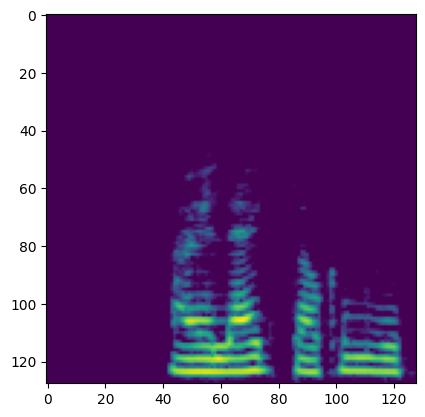

In [42]:
# Load image features
if os.path.exists(train_img_dir):
    train_data_img, train_files_img = scan_img_features(train_img_dir)

if os.path.exists(test_img_dir):
    test_data_img, test_files_img = scan_img_features(test_img_dir)

# Displaying an example image
plt.imshow(test_data_img[0])
plt.show()

In [43]:
# Function to get path labels
def get_path_labels(p):
    return [speech_data[speech_data['Filename'] == x].iloc[0, 1] for x in p]

# Get labels for training data
train_labels = get_path_labels(train_files)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Print shapes
print("Train Shape:", train_data.shape, "| Test Shape:", test_data.shape)

Train Shape: (110, 128, 128) | Test Shape: (250, 128, 128)


In [ ]:
# MelSpec to Images using Plotly
def save_img(f, fp):
    fig = go.Figure(data=go.Heatmap(z=f[::-1], colorscale='Viridis'))
    fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                      yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    pio.write_html(fig, fp)

In [ ]:
def save_feature_to_image(path, save_dir, avg_feat=0):
    global sample_rate
    files = sorted(os.listdir(path))
    print("Scanning", path)

    for i, fp in enumerate(files):
        X, sr = load_audio(os.path.join(path, fp))
        f = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        f = librosa.amplitude_to_db(f, ref=np.max)
        img = np.zeros((f.shape[0], avg_feat))
        x_width = min(f.shape[1], avg_feat)
        img[:, :x_width] = f[:, :x_width]
        fname = os.path.join(save_dir, fp.split('.')[0] + '.html')
        save_img(img, fname)

In [ ]:
# Set directories for training and test images
train_img_dir = '/content/train_images'
test_img_dir = '/content/test_images'

In [ ]:
# Create training image directory if not exists and save Mel spectrogram images
if not os.path.exists(train_img_dir):
    os.mkdir(train_img_dir)
    save_feature_to_image(trainset_data, train_img_dir, f_dim)

In [ ]:
# Create test image directory if not exists and save Mel spectrogram images using the same feature dimension as training data
if not os.path.exists(test_img_dir):
    os.mkdir(test_img_dir)
    save_feature_to_image(testset_data, test_img_dir, train_data.shape[2])

In [ ]:
# Scan image features from a directory
def scan_img_features(path):
    features = []
    files = sorted(os.listdir(path))

    for file_name in files:
        file_path = os.path.join(path, file_name)
        try:
            img = imread(file_path)[:,:,:3] / 255.0
            features.append(img)
        except Exception as e:
            print(f"Skipping {file_name} due to error: {e}")

    return np.array(features), files

In [ ]:
import plotly.io as pio
# Set the render mode to 'notebook'
pio.renderers.default = 'notebook_connected'

if os.path.exists(train_img_dir):
    train_data_img, train_files_img = scan_img_features(train_img_dir)
    for img in train_data_img:
        fig = go.Figure(data=go.Heatmap(z=img[::-1], colorscale='Viridis'))
        fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                          yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
        pio.show(fig)

if os.path.exists(test_img_dir):
    test_data_img, test_files_img = scan_img_features(test_img_dir)
    for img in test_data_img:
        fig = go.Figure(data=go.Heatmap(z=img[::-1], colorscale='Viridis'))
        fig.update_layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                          yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
        pio.show(fig)

Skipping 112.html due to error: Could not find a backend to open `/content/train_images/112.html`` with iomode `ri`.
Skipping 113.html due to error: Could not find a backend to open `/content/train_images/113.html`` with iomode `ri`.
Skipping 115.html due to error: Could not find a backend to open `/content/train_images/115.html`` with iomode `ri`.
Skipping 119.html due to error: Could not find a backend to open `/content/train_images/119.html`` with iomode `ri`.
Skipping 123.html due to error: Could not find a backend to open `/content/train_images/123.html`` with iomode `ri`.
Skipping 124.html due to error: Could not find a backend to open `/content/train_images/124.html`` with iomode `ri`.
Skipping 125.html due to error: Could not find a backend to open `/content/train_images/125.html`` with iomode `ri`.
Skipping 128.html due to error: Could not find a backend to open `/content/train_images/128.html`` with iomode `ri`.
Skipping 13.html due to error: Could not find a backend to open 